#  Neural Collaborative Filtering Recommendations

In this project we will be building a neural recommendation system using the Yelp dataset. This task illustrates the application of deep learning techniques in personalizing user experiences through recommendation systems. By analyzing Yelp's extensive data of businesses and reviews, we'll develop a model capable of suggesting restaurants to users based on their past ratings.

## 1 <span style='color:#e61227'>|</span> Setup

Before getting into the core of the project, we prepare our environment for the task at hand. This includes checking for GPU availability to leverage hardware acceleration for training our deep learning model, and importing necessary libraries.

In [25]:
import torch

# Check if a CUDA-enabled GPU is available for PyTorch to use, setting the device accordingly.
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('%d GPU(s) available' % torch.cuda.device_count())
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

1 GPU(s) available
Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [26]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torcheval.metrics as metrics
import os
import re
import tempfile
import ray
from ray import train, tune
from ray.train import Checkpoint, RunConfig
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.tune_config import TuneConfig
from ray.tune.tuner import Tuner
from ray.tune.analysis import ExperimentAnalysis

## 2 <span style='color:#e61227'>|</span> Data Preparation

### 2.1 <span style='color:#e61227'> |</span> Business Data

We start by loading and exploring the Yelp business data. Our focus is on restaurants located in New Orleans. This subset provides us with a manageable yet rich dataset for building our recommendation system.

In [27]:
# Load business data from the Yelp dataset JSON file, focusing on restaurant businesses in New Orleans.
business_df = pd.read_json('yelp-dataset/yelp_academic_dataset_business.json', lines=True)

# Define the business type of interest and the target city.
business_type = 'Restaurants'
city = 'New Orleans'

# Fill missing values in 'categories' with an empty string and filter the DataFrame for restaurants in New Orleans.
business_df['categories'] = business_df['categories'].fillna('')
business_df = business_df.query('categories.str.contains(@business_type) & city == @city')

# Count the number of businesses that match the criteria.
num_businesses = len(business_df)
print(f'{num_businesses} {business_type} in {city}')

# Extract business IDs for use in filtering the reviews dataset.
business_ids = business_df['business_id']
business_ids

2259 Restaurants in New Orleans


87        YNjyv0gfOr2g8lbmUpTnKg
103       TLZ3-eDPLhUzfsWO4ad6Ug
131       FRYkg_JvsWU9xIXZsEZcVA
231       4IcB3QyMEA85UTWFKh9O9A
253       Edg22x3CZkIv0GUib2oEFA
                   ...          
149934    ajM1U0EUVF8zKi-d-JKcDg
149959    2jFOIBICinZkepcO60rN0Q
150083    2OcVR4GRcmVsC118dn2QWA
150144    PBbhDFJdUS7ebuRa1ggjaQ
150212    _eafo0pYcxOvziwR4JXj_Q
Name: business_id, Length: 2259, dtype: object

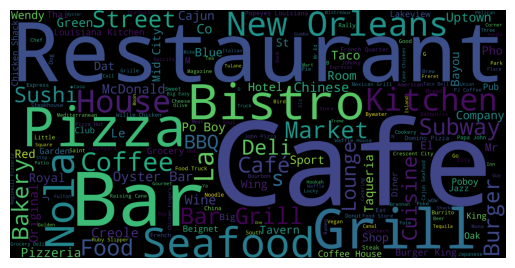

In [28]:
# Prepare business names for a word cloud visualization by concatenating them into a single string.
business_df['name'] = business_df['name'].fillna("").astype('str')
title_corpus = ' '.join(business_df['name'])

# Generate and display a word cloud of business names to visualize their frequency.
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

### 2.2 <span style='color:#e61227'> |</span> Review Data

The review dataset from Yelp is vast, necessitating the use of chunking for efficient processing. We filter reviews to include only those relevant to the businesses of interest and further refine our dataset to focus on active users with more than 50 reviews. This filtering ensures the model learns from users with a significant interaction history, potentially improving the recommendations' relevance.

In [29]:
# Load review data in chunks to manage memory usage, filtering reviews for the selected businesses.
reviews_df_iter = pd.read_json('yelp-dataset/yelp_academic_dataset_review.json', chunksize=1000000, lines=True)

# Initialize an empty DataFrame to hold the filtered reviews.
reviews_df = pd.DataFrame()
# Iterate over chunks, filtering reviews based on business IDs, and concatenate them to the DataFrame.
for df in reviews_df_iter:
    df = df.query('business_id in @business_ids')
    reviews_df = pd.concat([reviews_df, df])

# Group the reviews by user ID and count the number of reviews per user, selecting those with more than 50 reviews.
count_per_user = reviews_df.groupby('user_id')['business_id'].count()
users = count_per_user[count_per_user > 50].index.tolist()
reviews_df = reviews_df.query('user_id in @users')

# Drop unnecessary columns from the reviews dataset, keeping only user IDs and business IDs.
reviews_df = reviews_df.drop(['review_id', 'useful', 'funny', 'cool', 'date', 'text'], axis=1)
reviews_df.head()

,user_id,business_id,stars
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4
78,07aVWNhBhpwqW3MdqoKDKQ,jLerIZFpe25jOUf722qzBA,3
381,Xw7ZjaGfr0WNVt6s_5KZfA,i-tDq8zC7ZmSqSbg_7oddA,5
617,L1ayZt4pBRKhO00OhUaLAw,neWdmzHgbpqSx62jynDd7A,3
1033,Xw7ZjaGfr0WNVt6s_5KZfA,Iso6F11o-W4g6d7OUEaMng,4


In [30]:
# Factorize the user and business IDs to convert them into numeric indices suitable for machine learning models.
reviews_df['user_id'], _ = pd.factorize(reviews_df['user_id'])
reviews_df['business_id'], _ = pd.factorize(reviews_df['business_id'])
reviews_df.head()

,user_id,business_id,stars
4,0,0,4
78,1,1,3
381,2,2,5
617,3,3,3
1033,2,4,4


In [31]:
# Print the total number of users, businesses and reviews after all filtering.
num_users = len(reviews_df['user_id'].unique())
print(f'{num_users} users')
print(f"{len(reviews_df['business_id'].unique())} businesses")
print(f'{len(reviews_df)} reviews')

340 users
2045 businesses
33094 reviews


## 3 <span style='color:#e61227'>|</span> Recommendation System 

### 3.1 <span style='color:#e61227'> |</span> Datasets

The data is split into training, validation, and test sets with a custom strategy that ensures user-specific transactions are appropriately divided, enabling the model to learn from a variety of user interactions and to be validated and tested on unseen data accurately.

In [32]:
# Split the dataset into training, validation, and test sets based on user interactions.
train_indices = []
validation_indices = []
test_indices = []

# Group the DataFrame by user_id and process each group.
for _, peruser_df in reviews_df.groupby('user_id'):
    n = len(peruser_df)
    # Training set: All but the last 10 interactions per user.
    train_indices.extend(peruser_df.index[:n-10]) 
    # Validation set: The next 5 interactions after the training set per user.
    validation_indices.extend(peruser_df.index[n-10:n-5]) 
    # Test set: The last 5 interactions per user.
    test_indices.extend(peruser_df.index[n-5:]) 

# Use the indices to create the actual dataset splits.
train_df = reviews_df.loc[train_indices]
val_df = reviews_df.loc[validation_indices]
test_df = reviews_df.loc[test_indices]

# Define a PyTorch Dataset for handling the recommendation data.
class RecommenderDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rows = self.data.iloc[idx].to_dict()
        # Ensure the 'stars' column is formatted correctly for PyTorch.
        if 'stars' in rows.keys():
            rows['stars'] = torch.tensor(rows['stars']).unsqueeze(-1).float()
        # Convert user_id and business_id to tensors.
        rows['user_id'] = torch.tensor(rows['user_id']).long()
        rows['business_id'] = torch.tensor(rows['business_id']).long()
        return rows

# Instantiate datasets for training, validation, and testing.
train_dataset = RecommenderDataset(train_df)
val_dataset = RecommenderDataset(val_df)
test_dataset = RecommenderDataset(test_df)

# Create a DataLoader for the test set.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 3.2 <span style='color:#e61227'> |</span> Model Architecture

Our model architecture combines Generalized Matrix Factorization (GMF) and Multi-Layer Perceptron (MLP) approaches, integrating user and item (business) embeddings into a unified framework for recommendation. This ensemble approach aims to capture both the linear interactions through GMF and the non-linear patterns through MLP, culminating in a rich representation of user preferences and item characteristics. The GMF and MLP model components are pre-trained as individual predictors in order to obtain a reliable initialization of their parameters.

In [33]:
class RecommenderGMF(nn.Module):
    """
    Generalized Matrix Factorization (GMF) part of the Neural Collaborative Filtering framework.
    """
    def __init__(self, config):
        super(RecommenderGMF, self).__init__()
        num_users = config['num_users']
        num_items = config['num_items']
        num_factors = config['num_factors']
        
        # Embeddings for users and items.
        self.embed_user_gmf = nn.Embedding(num_users, num_factors)
        nn.init.normal_(self.embed_user_gmf.weight, std=0.01)
        self.embed_item_gmf = nn.Embedding(num_items, num_factors)
        nn.init.normal_(self.embed_item_gmf.weight, std=0.01)
        
        # Output layer to predict the interaction score.
        self.output = nn.Linear(num_factors, 1)
        nn.init.kaiming_uniform_(self.output.weight, a=1, nonlinearity='sigmoid')

    def get_features(self, user_id, item_id):
        # Fetch user and item embeddings and perform element-wise multiplication.
        embedded_user_gmf = self.embed_user_gmf(user_id)
        embedded_item_gmf = self.embed_item_gmf(item_id)
        features_gmf = torch.mul(embedded_user_gmf, embedded_item_gmf)
        return features_gmf

    def forward(self, user_id, item_id):
        # Get features and pass them through the output layer to get predictions.
        features = self.get_features(user_id, item_id)
        prediction = self.output(features)
        return prediction


class RecommenderMLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) part of the Neural Collaborative Filtering framework.
    """
    def __init__(self, config):
        super(RecommenderMLP, self).__init__()
        num_users = config['num_users']
        num_items = config['num_items']
        num_factors = config['num_factors']
        user_factors_ratio = config['user_factors_ratio']
        num_layers = config['num_layers']

        # Calculate user and item embedding sizes based on configuration.
        user_portion = int(num_factors * user_factors_ratio)
        user_embed_size = user_portion * (2 ** num_layers)
        item_embed_size = (num_factors - user_portion) * (2 ** num_layers)

        # User and item embeddings.
        self.embed_user_mlp = nn.Embedding(num_users, user_embed_size)
        nn.init.normal_(self.embed_user_mlp.weight, std=0.01)
        self.embed_item_mlp = nn.Embedding(num_items, item_embed_size)
        nn.init.normal_(self.embed_item_mlp.weight, std=0.01)

        # MLP layers.
        mlp_modules = []
        for i in range(num_layers):
            input_size = num_factors * (2 ** (num_layers - i))
            mlp_modules.append(nn.Linear(input_size, input_size // 2))
            mlp_modules.append(nn.ReLU())
        self.mlp_layers = nn.Sequential(*mlp_modules)

        # Initialize weights for the MLP layers.
        for m in self.mlp_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        
        # Output layer to predict the interaction score.
        self.output = nn.Linear(num_factors, 1)
        nn.init.kaiming_uniform_(self.output.weight, a=1, nonlinearity='sigmoid')

    def get_features(self, user_id, item_id):
        # Fetch user and item embeddings, concatenate them, and pass through MLP layers.
        embedded_user_mlp = self.embed_user_mlp(user_id)
        embedded_item_mlp = self.embed_item_mlp(item_id)
        vector_mlp = torch.cat([embedded_user_mlp, embedded_item_mlp], dim=1)
        features_mlp = self.mlp_layers(vector_mlp)
        return features_mlp

    def forward(self, user_id, item_id):
        # Get features and pass them through the output layer to get predictions.
        features = self.get_features(user_id, item_id)
        prediction = self.output(features)
        return prediction


class RecommenderEnsemble(nn.Module):
    """
    Ensemble model that combines GMF and MLP models.
    """
    def __init__(self, config):
        super(RecommenderEnsemble, self).__init__()
        # Number of latent factors for user and item embeddings.
        num_factors = config['num_factors']

        # Instantiate GMF and MLP models from the config.
        self.gmf = config['gmf_model']
        self.mlp = config['mlp_model']
        
        # Output layer to predict the final interaction score by combining GMF and MLP features.
        self.output = nn.Linear(num_factors, 1)
        nn.init.kaiming_uniform_(self.output.weight, a=1, nonlinearity='sigmoid')

    def forward(self, user_id, item_id):
        # Get features from GMF and MLP, combine them, and predict the final score.
        vector_gmf = self.gmf.get_features(user_id, item_id)
        vector_mlp = self.mlp.get_features(user_id, item_id)
        combined_vector = torch.cat([vector_gmf, vector_mlp], dim=1)
        prediction = self.output(combined_vector)
        return prediction

### 3.3 <span style='color:#e61227'> |</span> Training

All three models are trained using an Adam optimizer with Mean Squared Error (MSE) loss. Ray Tune's Population-Based Training (PBT) is employed for hyperparameter tuning, dynamically adjusting learning rates and model architecture parameters to improve performance over time. The tuning process is visualized, showing the RMSE improvement across training iterations.

##### 3.3.1 <span style='color:#e61227'> |</span> Utilities

In [34]:
# Function to load the latest checkpoint, and update the model, optimizer, and step number.
def load_checkpoint(config, model, optimizer, step):
    # Retrieve the latest checkpoint if available.
    checkpoint = train.get_checkpoint()
    if checkpoint:
        # Load the checkpoint.
        with checkpoint.as_directory() as checkpoint_dir:
            checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))

        # Load model and optimizer states.
        model.load_state_dict(checkpoint_dict["model_state_dict"])
        optimizer.load_state_dict(checkpoint_dict["optimizer_state_dict"])
        
        # Update learning rate in the optimizer if specified in the config.
        for param_group in optimizer.param_groups:
            if "learning_rate" in config:
                param_group["learning_rate"] = config["learning_rate"]

        # Set the step number to the last saved step.
        last_step = checkpoint_dict["step"]
        step = last_step + 1
    return model, optimizer, step
        

# Function to save the model and optimizer states at the current training step.
def tune_report(step, config, model, optimizer, metrics):
    # Report metrics and save checkpoints at specified intervals.
    if step % config["checkpoint_interval"] == 0:
        with tempfile.TemporaryDirectory() as tmpdir:
            # Save the current model and optimizer states along with the step number.
            torch.save(
                {
                    "step": step,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                },
                os.path.join(tmpdir, "checkpoint.pt"),
            )
            # Report the metrics and checkpoint for this training step.
            train.report(metrics, checkpoint=Checkpoint.from_directory(tmpdir))
    else:
        # Report metrics without saving a new checkpoint.
        train.report(metrics)
            

# Function to train the model for one epoch.
def train_epoch(model, train_loader, criterion, optimizer):
    # Set the model to training mode.
    model.train()
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        # Transfer batch data to the device.
        batch = {k: v.to(device) for k, v in batch.items()}
        # Prepare model inputs from the batch.
        input = {'user_id': batch['user_id'], 'item_id': batch['business_id']}
        optimizer.zero_grad()        
        # Forward pass: compute predicted outputs by passing inputs to the model.
        output = model(**input)
        # Calculate the loss.
        loss = criterion(output, batch['stars'].to(device))
        # Backward pass: compute gradient of the loss with respect to model parameters.
        loss.backward()
        # Perform a single optimization step (parameter update).
        optimizer.step()
        # Update running training loss.
        running_loss += loss.item()
    # Return average loss for the epoch.
    return running_loss / len(train_loader)


# Function to validate the model for one epoch.
def validate_epoch(model, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode.
    running_loss = 0.0
    targets = []
    outputs = []
    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations.
        for i, batch in enumerate(val_loader):
            # Transfer batch data to the device.
            batch = {k: v.to(device) for k, v in batch.items()}
            # Prepare model inputs from the batch.
            input = {'user_id': batch['user_id'], 'item_id': batch['business_id']}
            target = batch['stars'].to(device)
            # Forward pass: compute predicted outputs by passing inputs to the model.
            output = model(**input)
            # Calculate the loss.
            loss = criterion(output, target)
            # Update running validation loss.
            running_loss += loss.item()
            outputs.extend(output)
            targets.extend(target)
    # Calculate average loss and performance metrics.
    avg_loss = running_loss / len(val_loader)
    targets, outputs = torch.cat(targets), torch.cat(outputs)    
    rmse = torch.sqrt(metrics.functional.mean_squared_error(outputs, targets)).item()
    return avg_loss, rmse


# Function to perform the training loop for a given model configuration.
def train_func(config, model_class, training_dataset, validation_dataset):
    # Initialize the model with the given configuration and transfer it to the appropriate device.
    model = model_class(config).to(device)
    criterion = nn.MSELoss()  # Define the loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])  # Define the optimizer.
    
    # Prepare DataLoaders for training and validation datasets.
    batch_size = config['batch_size']
    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    
    step = 1
    # Load the latest checkpoint if available and update the model, optimizer, and step number.
    model, optimizer, step = load_checkpoint(config, model, optimizer, step)
    
    while True:  # Training loop.
        # Train for one epoch and validate.
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_rmse = validate_epoch(model, val_loader, criterion)
        # Report metrics and checkpoint if necessary.
        tune_report(step, config, model, optimizer, {"rmse": val_rmse})
        step += 1

In [49]:
# Function to configure and execute the model tuning process using Ray Tune and Population-Based Training (PBT).
def tune_model(model_class, param_space, mutate_config, training_dataset, validation_dataset, training_iters=10):
    # Shutdown Ray if it's already initialized to reset its state.
    if ray.is_initialized():
        ray.shutdown()
    # Define the resources for Ray; here we specify the CPU and GPU resources to be used.
    resources = {"cpu": 8, "gpu": 1}
    # Initialize Ray with the specified resources.
    ray.init(resources=resources)

    # Define parameters for Population-Based Training (PBT).
    pbt_scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        perturbation_interval=2,  # How often to apply perturbations.
        resample_probability=1,
        hyperparam_mutations=mutate_config,  # Allowed hyperparameter mutations.
        synch=True,
    )

    # Configure and initialize the tuner for the hyperparameter tuning.
    tuner = Tuner(
        tune.with_resources(
            tune.with_parameters(
                train_func,  # The training function to be tuned.
                model_class=model_class,
                training_dataset=training_dataset, 
                validation_dataset=validation_dataset,
            ),
            resources=resources,
        ),
        param_space=param_space,  # The hyperparameter space.
        tune_config=TuneConfig(
            num_samples=1,  # Number of times to sample from the hyperparameter space.
            metric="rmse",  # The metric to optimize.
            mode="min",  # The optimization mode, minimizing the metric.
            scheduler=pbt_scheduler,  # The scheduler for hyperparameter tuning.
        ),
        run_config=RunConfig(
            stop={"training_iteration": training_iters},  # Stopping condition.
        ),
    )
    # Start the tuning process and return the results.
    return tuner.fit()
    
    
# Function to extract the results directory of the experiment given the path of a specific trial.
def get_ray_results_path(input_string):
    # Adjusted regular expression to match up to the first date.
    pattern = r'(.*?\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})'
    
    # Attempt to find a match in the input string.
    match = re.match(pattern, input_string)
    
    # If a match is found, return the matched part, otherwise return None.
    return match.group(0) if match else None


# Function to save the best model of the tuning process.
def save_best_model(model_class, results_grid, best_last=False):
    # Retrieve the best training instance based on minimum rmse.
    if best_last:    # Look at the last iteration.
        best_result = results_grid.get_best_result("rmse", "min")
    else:    # Look at all iterations.
        best_result = results_grid.get_best_result("rmse", "min", "all")
    best_config = best_result.config  # The configuration of the best trial.
    
    filtered_best_config = {
        key: value for key, value in best_config.items() 
        if not any([constant in key for constant in ['num_users', 'num_items', 'model', 'checkpoint']])
    }  # Print only the config params that were tuned.
    print(f"Best trial config: {filtered_best_config}")
    print(f"Best trial final validation RMSE: {best_result.metrics['rmse']}")
    
    # Locate the best checkpoint.
    best_checkpoint_path = best_result.checkpoint.path
    
    # Initialize a model object.
    best_model = model_class(best_config).to(device)
    
    # Load the best checkpoint.
    best_checkpoint = torch.load(os.path.join(best_checkpoint_path, 'checkpoint.pt'))
    best_model.load_state_dict(best_checkpoint['model_state_dict'])
    
    # Save the best model for future use.
    torch.save(best_model, f'best_{model_class.__name__}.pt')
    return best_config['num_factors']


# Function to visualize the results of the tuning process.
def plot_trials(results_grid, analysis):
    # Look up the values each hyperparameter took during each trial.
    trial_labels = []
    for i, trial in enumerate(sorted(analysis.trial_dataframes)):
        df = analysis.trial_dataframes[trial]
        param_progress = [
            f'{column.split("config/", 1)[1]}: ' + ' \u2192 '.join(df[column].drop_duplicates().round(8).astype(str)) 
            for column in df.columns 
            if column.startswith('config/') and not any([constant in column for constant in ['num_users', 'num_items', 'model', 'checkpoint']])
        ]
        trial_labels += [f'trial {i} - {", ".join(param_progress)}']

    # Visualize the validation RMSE across all trials.
    colors = plt.cm.jet(torch.linspace(0, 1, len(trial_labels)).numpy())
    plt.figure(figsize=(10, 8 + len(colors) // 10 * 1.75))
    for i, result in enumerate(results_grid):
        result_df = result.metrics_dataframe # DataFrame of the trial's metrics.
        plt.plot(
            result_df["rmse"], 
            label = trial_labels[i],
            color=colors[i],
        ) 
    plt.yscale('log')  # Use logarithmic scale for better visibility of changes.
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set the x-axis to show only integer values.
    plt.xlabel("Training Iterations")
    plt.ylabel("Validation RMSE")
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075), fontsize="small")
    plt.tight_layout()
    plt.show()
    

# Function to be used after the tuning process. Plots the trial results and saves the best model.
def exploit_tune_results(model_class, results_grid):
    # Locate the results directory.
    results_dir = get_ray_results_path(results_grid[0].path)
    
    # Instantiate the ExperimentAnalysis object with the specified results directory.
    analysis = ExperimentAnalysis(experiment_checkpoint_path=results_dir)

    # Display the tuning results.
    plot_trials(results_grid, analysis)
    
    # Save the best-performing model.
    num_factors = save_best_model(model_class, results_grid)
    return num_factors

##### 3.3.2 <span style='color:#e61227'> |</span> GMF training

In [ ]:
# Initiate the hyperparameter tuning process for pre-training the GMF model.
param_space = {
    'num_users': num_users, 
    'num_items': num_businesses,
    'num_factors': tune.grid_search([8, 16]),
    'batch_size': tune.grid_search([16, 32]),
    'learning_rate': tune.grid_search([1e-3, 1e-4]),
    'checkpoint_interval': 2,
}
mutate_config = {
    'learning_rate': tune.qloguniform(1e-5, 1e-3, 5e-6),
}
results_grid_gmf = tune_model(RecommenderGMF, param_space, mutate_config, train_dataset, val_dataset)

(train_func pid=19428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=C:/Users/anna1/ray_results/train_func_2024-04-16_21-27-26/train_func_bd57f_00007_7_batch_size=32,learning_rate=0.0001,num_factors=16_2024-04-16_21-27-26/checkpoint_000003)


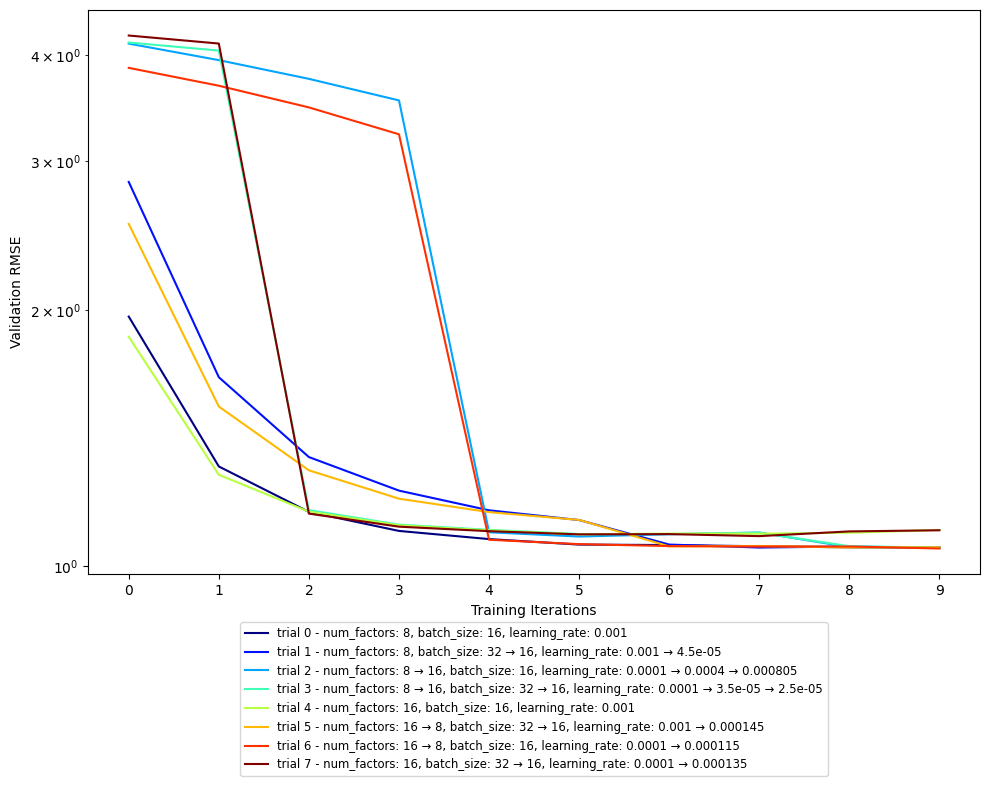

Best trial config: {'num_factors': 8, 'batch_size': 16, 'learning_rate': 0.000115}
Best trial final validation RMSE: 1.04912269115448


In [51]:
# Plot the tuning results and save the best GMF model.
num_factors_gmf = exploit_tune_results(RecommenderGMF, results_grid_gmf)

##### 3.3.3 <span style='color:#e61227'> |</span> MLP training

In [ ]:
# Initiate the hyperparameter tuning process for pre-training the MLP model.
param_space = {
    'num_users': num_users, 
    'num_items': num_businesses,
    'num_layers': tune.grid_search([3, 4]),
    'user_factors_ratio': tune.grid_search([0.5, 0.7]),
    'num_factors': tune.grid_search([8, 16]),
    'batch_size': tune.grid_search([16, 32]),
    'learning_rate': tune.grid_search([1e-3, 1e-4]),
    'checkpoint_interval': 2,
}
mutate_config = {
    'learning_rate': tune.qloguniform(1e-5, 1e-3, 5e-6),
}
results_grid_mlp = tune_model(RecommenderMLP, param_space, mutate_config, train_dataset, val_dataset)

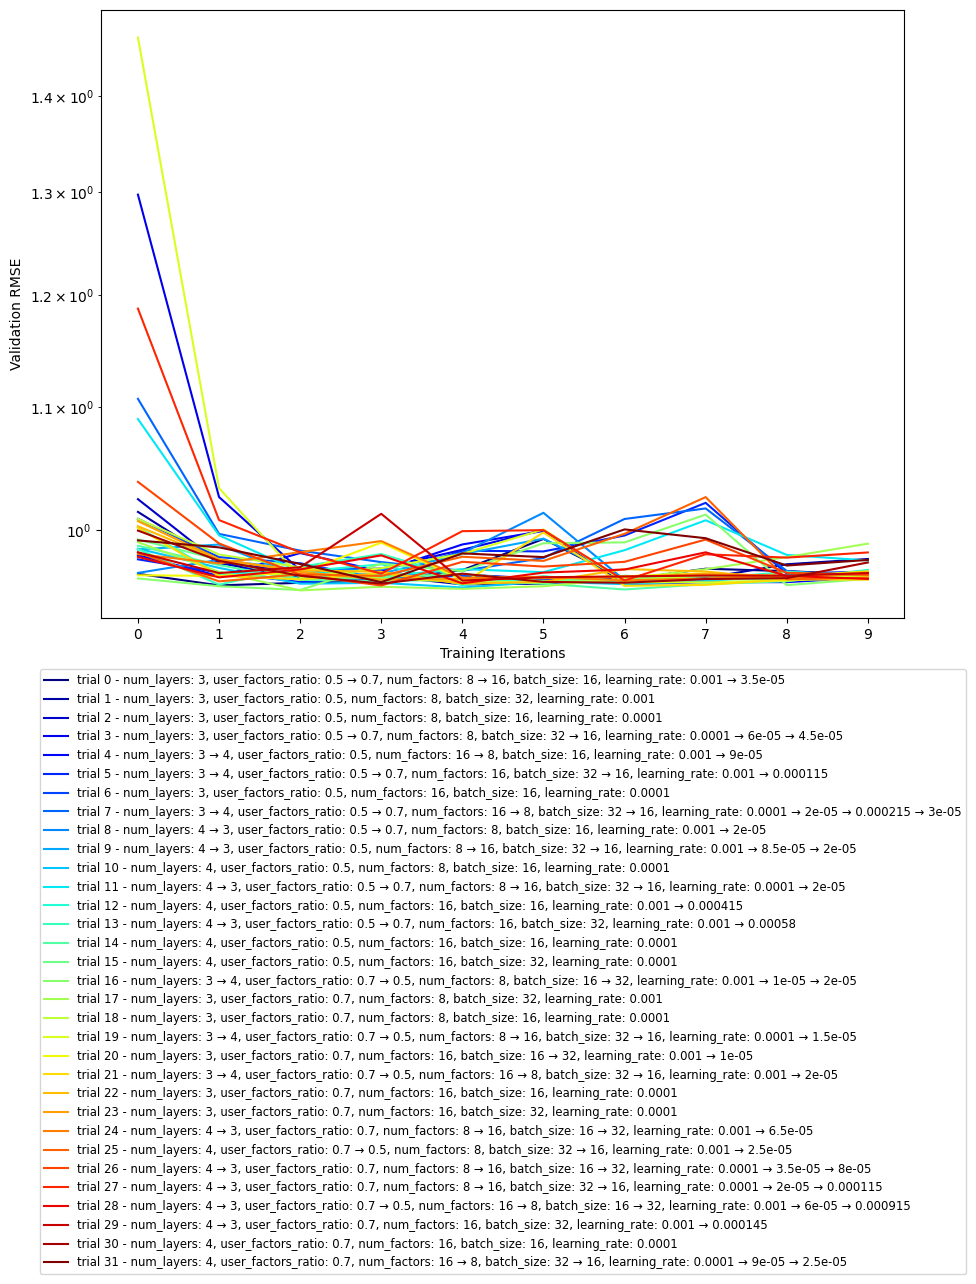

Best trial config: {'num_layers': 3, 'user_factors_ratio': 0.7, 'num_factors': 8, 'batch_size': 32, 'learning_rate': 0.001}
Best trial final validation RMSE: 0.9896321892738342


In [53]:
# Plot the tuning results and save the best MLP model.
num_factors_mlp = exploit_tune_results(RecommenderMLP, results_grid_mlp)

##### 3.3.4 <span style='color:#e61227'> |</span> Ensemble training

In [ ]:
# Initiate the hyperparameter tuning process for training the GMF+MLP ensemble model.
param_space = {
    'gmf_model': torch.load(f'best_RecommenderGMF.pt'),
    'mlp_model': torch.load(f'best_RecommenderMLP.pt'),
    'num_factors': num_factors_gmf + num_factors_mlp,
    'batch_size': tune.grid_search([16, 32]),
    'learning_rate': tune.grid_search([1e-3, 1e-4]),
    'checkpoint_interval': 2,
}
mutate_config = {
    'learning_rate': tune.qloguniform(1e-5, 1e-3, 5e-6),
}
results_grid = tune_model(RecommenderEnsemble, param_space, mutate_config, train_dataset, val_dataset)

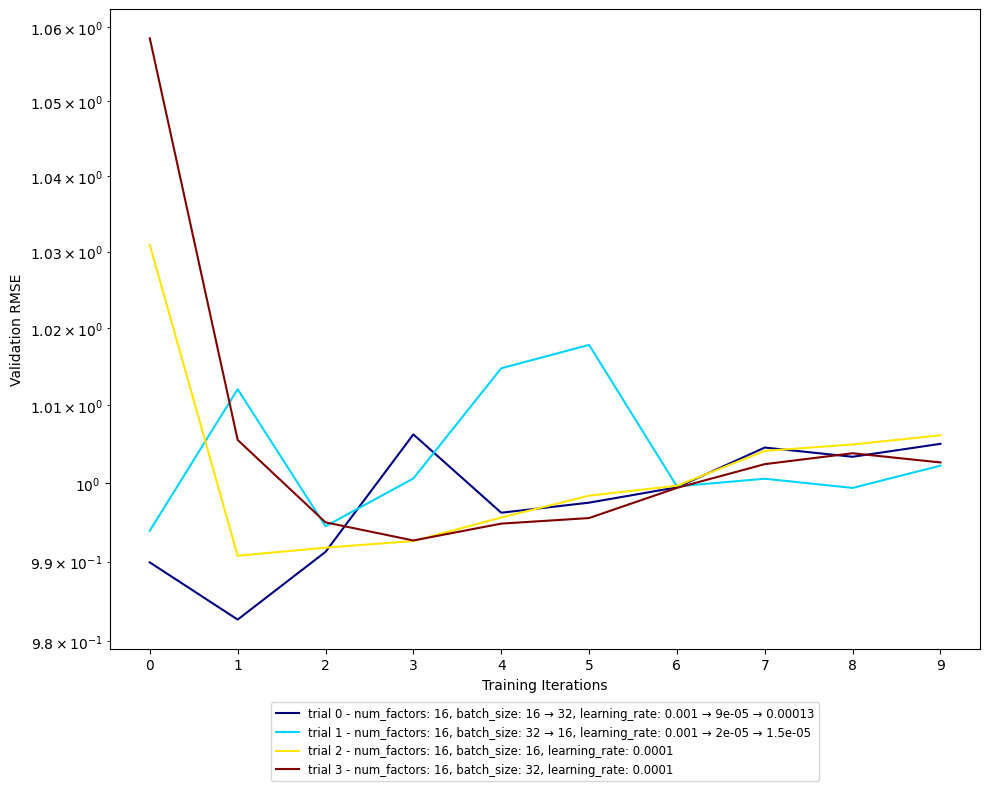

Best trial config: {'num_factors': 16, 'batch_size': 32, 'learning_rate': 0.00013000000000000002}
Best trial final validation RMSE: 1.0050348043441772


In [82]:
# Plot the tuning results and save the best ensemble model.
exploit_tune_results(RecommenderEnsemble, results_grid);

### 3.4 <span style='color:#e61227'> |</span> Inference

We evaluate the models' predictive capability on the test dataset, calculating the Root Mean Square Error (RMSE). This step is crucial in understanding their generalization ability to unseen data.

In [83]:
def test_model(model, test_loader):
    
    def predict(model, test_loader):
        model.eval()  # Set the model to evaluation mode.
        outputs = []
        targets = []
        with torch.no_grad():  # Disable gradient computation for inference.
            for batch in test_loader:
                # Transfer batch data to the same device as the model.
                batch = {k: v.to(device) for k, v in batch.items()}
                # Prepare input for the model.
                input = {'user_id': batch['user_id'], 'item_id': batch['business_id']}
                # Perform the forward pass and store predictions.
                output = model(**input)
                outputs.extend(output)
                targets.extend(batch['stars'])
                
        # Concatenate lists of outputs and targets into tensors.
        return torch.cat(outputs), torch.cat(targets)

    # Get the model predictions and the corresponding actual ratings.
    test_predictions, test_targets = predict(model, test_loader)

    # Calculate the Root Mean Square Error (RMSE) between predictions and real values.
    rmse = torch.sqrt(metrics.functional.mean_squared_error(test_predictions, test_targets))
    print(f'{model.__class__.__name__} Test RMSE: {rmse:.4f}')

In [84]:
# Load the best GMF model.
best_model = torch.load(f'best_RecommenderGMF.pt')

# Evaluate the model on the test dataset.
test_model(best_model, test_loader)

RecommenderGMF Test RMSE: 1.1324


In [85]:
# Load the best MLP model.
best_model = torch.load(f'best_RecommenderMLP.pt')

# Evaluate the model on the test dataset.
test_model(best_model, test_loader)

RecommenderMLP Test RMSE: 1.0129


In [86]:
# Load the best ensemble model.
best_model = torch.load(f'best_RecommenderEnsemble.pt')

# Evaluate the model on the test dataset.
test_model(best_model, test_loader)

RecommenderEnsemble Test RMSE: 1.0195


Analysis of the results:
- **GMF model**: Has the highest RMSE among the three, suggesting it has the poorest prediction accuracy in this setup. This could be because GMF, relying purely on matrix factorization, may not capture complex interactions as effectively as models that include non-linear transformations.
- **MLP model**: Shows significantly better performance compared to the GMF. The lower RMSE indicates that the MLP's ability to model non-linear interactions between users and items leads to more accurate predictions. This is typically expected as MLPs can learn more complex patterns in the data.
- **Ensemble model**: Has a slightly higher RMSE than the MLP model alone but significantly lower than the GMF. This suggests that the ensemble model successfully leverages information from both models to enhance performance, although it does not surpass the MLP model in this particular case.

Implications:
- **MLP Effectiveness**: The MLP model outperforms the GMF, indicating that in our specific scenario, the data might have complex patterns better captured by the non-linear capabilities of MLPs.
- **Ensemble Model's Role**: Although the ensemble model does not outperform the MLP model, it still improves upon the GMF model. This suggests that combining the models does provide a benefit, though it seems that the MLP's contribution is dominant. One potential reason the ensemble did not perform better than the MLP alone could be due to how the features from GMF and MLP are combined.
- **Ensemble Strategy**: Experimenting with different ways of combining the features from the GMF and MLP components could allow us to better capture the complementary strengths of both models. For example, rather than simply concatenating their features, we might look into using feature transformation or an attention mechanism before combination.

### 3.5 <span style='color:#e61227'> |</span> Application

Finally, we can employ our model to recommend restaurants for an example user based on their historical interactions. By predicting ratings for a set of unseen businesses, we identify top recommendations, showcasing the model's practical utility in a real-world application.

In [87]:
# Retrieve unique business IDs and filter out those already reviewed by user_0.
business_ids = reviews_df['business_id'].drop_duplicates()
user_0_history = reviews_df.query('user_id == 0')['business_id']

# Create a DataFrame with all businesses that can be potentially recommended to user 0.
example_df = pd.DataFrame({'business_id': business_ids, 'user_id': 0}).query('business_id not in @user_0_history')
example_df

,business_id,user_id
78,1,0
381,2,0
617,3,0
1033,4,0
1113,5,0
...,...,...
6907263,2040,0
6954251,2041,0
6958126,2042,0
6967088,2043,0


In [88]:
# Load the best model for making predictions.
best_model = torch.load(f'best_RecommenderEnsemble.pt')

# Prepare the data for inference.
infer_dataset = RecommenderDataset(example_df)
infer_loader = DataLoader(infer_dataset, batch_size=16, shuffle=False)

best_model.eval()  # Set the model to evaluation mode.
predictions = []
with torch.no_grad():  # Disable gradient computation during inference.
    for batch in infer_loader:
        # Transfer batch data to the device.
        batch = {k: v.to(device) for k, v in batch.items()}
        # Prepare input and predict ratings.
        input = {'user_id': batch['user_id'], 'item_id': batch['business_id']}
        output = best_model(**input)
        predictions.extend(output)
    
# Convert list of predictions to a tensor and attach to the DataFrame as a new column.
predictions = torch.cat(predictions)
example_df['predicted_rating'] = predictions.cpu().numpy()
example_df

,business_id,user_id,predicted_rating
78,1,0,3.469329
381,2,0,0.887590
617,3,0,2.855969
1033,4,0,2.747278
1113,5,0,4.225920
...,...,...,...
6907263,2040,0,2.692956
6954251,2041,0,2.619009
6958126,2042,0,2.753880
6967088,2043,0,2.741013


In [89]:
# Extract and display the top 10 recommended businesses based on predicted ratings.
example_df.nlargest(10, 'predicted_rating')

,business_id,user_id,predicted_rating
1661803,549,0,5.316947
585432,208,0,5.251207
5723018,1788,0,5.234786
4937933,1544,0,5.204534
1960466,592,0,5.200486
4370167,1383,0,5.179940
6328888,1931,0,5.173684
2137497,626,0,5.163425
1817887,571,0,5.134451
513794,201,0,5.125619
